
# Netflix Dataset Analysis

## 1. Introduction to Dataset
The dataset under consideration is a Netflix dataset containing ~7,789 records and 11 columns. It includes important details about Movies and TV Shows available on the platform. Key attributes include the title, director, cast, country of origin, release date, rating, duration, and type (genres). The dataset spans multiple years, with entries ranging from 2008 to 2021, covering content across diverse countries and genres.

## 2. Problem Statement
Netflix has become one of the most prominent global streaming platforms, continuously expanding its library with a mix of original productions and licensed content. However, with growing competition from platforms like Amazon Prime, Disney+, and regional OTT providers, Netflix must strategically analyze its content catalog to identify strengths, gaps, and opportunities.
The specific problem to be addressed in this project is **'Content Trends Analysis for Strategic Recommendations'**. The aim is to uncover how Netflix’s content distribution (Movies vs. TV Shows, genres, and country contributions) has evolved over the years to enable identification of key genres, audience preferences, and strategic insights into global content expansion.

## 3. Importance of the Problem Statement
Understanding Netflix’s content trends is crucial for making data-driven business decisions. The analysis not only highlights the balance between Movies and TV Shows but also reveals popular genres and underrepresented categories. For a platform that serves diverse international audiences, country-wise contributions provide valuable insights into global representation and market penetration.

## 4. Objectives
- Analyze the distribution of Movies vs. TV Shows over the years.
- Identify the most common genres and how their popularity has changed.
- Compare country-wise contributions to Netflix’s catalog.
- Apply simple ML techniques: clustering to find content groups, and forecasting to model trends
## 5. Expected Outcomes
- A clear understanding of how Netflix’s content strategy has evolved.
- Identification of top-performing genres and categories.
- Strategic recommendations on which content types Netflix should focus on in the future.


In [13]:

# Environment setup and dynamic upload (works in Colab)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from google.colab import files
import io, sys, warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

print('Please upload your Netflix CSV when prompted (any file name ending with .csv).')
uploaded = files.upload()
if len(uploaded) == 0:
    raise FileNotFoundError('No file uploaded. Please upload the CSV and re-run the cell.')

# Use the first uploaded file
fname = list(uploaded.keys())[0]
print('Uploaded filename detected:', fname)
df = pd.read_csv(io.BytesIO(uploaded[fname]))
# Save a copy to /content for consistency with earlier notebook versions
save_path = Path('/content/Netflix Dataset.csv')
df.to_csv(save_path, index=False)
print('Saved a copy to', save_path)
print('Shape:', df.shape)
display(df.head(5))


Please upload your Netflix CSV when prompted (any file name ending with .csv).


Saving Netflix Dataset.csv to Netflix Dataset (1).csv
Uploaded filename detected: Netflix Dataset (1).csv
Saved a copy to /content/Netflix Dataset.csv
Shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Data Overview and Cleaning
We perform initial cleaning: normalize column names, parse dates, and inspect missing values.
## Feature Engineering
Create useful columns: exploded genres, exploded countries, and parsed duration.

In [14]:

# Data preprocessing: standardize column names, extract year, normalize genre/duration columns
df.columns = [c.strip() for c in df.columns]

# Create a colmap for detected columns
colmap = {'listed_in': None, 'duration': None, 'date': None, 'release_year': None,
          'type': None, 'country': None, 'rating': None, 'title': None, 'director': None, 'cast': None, 'category': None}

for c in df.columns:
    lc = c.lower()
    if ('list' in lc or 'genre' in lc) and colmap['listed_in'] is None:
        colmap['listed_in'] = c
    if 'duration' in lc and colmap['duration'] is None:
        colmap['duration'] = c
    if 'date' in lc and colmap['date'] is None:
        colmap['date'] = c
    if 'release' in lc and 'year' in lc and colmap['release_year'] is None:
        colmap['release_year'] = c
    if lc == 'type' and colmap['type'] is None:
        colmap['type'] = c
    if 'category' in lc and colmap['category'] is None:
        colmap['category'] = c
    if 'country' in lc and colmap['country'] is None:
        colmap['country'] = c
    if 'rating' in lc and colmap['rating'] is None:
        colmap['rating'] = c
    if 'title' in lc and colmap['title'] is None:
        colmap['title'] = c
    if 'director' in lc and colmap['director'] is None:
        colmap['director'] = c
    if ('cast' in lc or 'actor' in lc) and colmap['cast'] is None:
        colmap['cast'] = c

print('Detected columns mapping:')
for k,v in colmap.items():
    print(f'  {k}: {v}')

# If the dataset uses 'Type' or 'Category' as the genres column, rename to 'listed_in'
if colmap['listed_in'] is None:
    for candidate in ['type', 'category']:
        c = colmap.get(candidate)
        if c and c in df.columns:
            df.rename(columns={c: 'listed_in'}, inplace=True)
            colmap['listed_in'] = 'listed_in'
            print(f"Renamed column {c} -> listed_in for genre analysis.")
            break

# Extract year: prefer any 'date' column (Release_Date etc.), else release_year if present
if colmap['date'] and colmap['date'] in df.columns:
    try:
        df['release_date_parsed'] = pd.to_datetime(df[colmap['date']], errors='coerce')
        df['year'] = df['release_date_parsed'].dt.year
        print('Extracted year from', colmap['date'])
    except Exception as e:
        print('Could not parse date column:', e)
elif colmap['release_year'] and colmap['release_year'] in df.columns:
    df['year'] = pd.to_numeric(df[colmap['release_year']], errors='coerce').astype('Int64')
else:
    df['year'] = pd.NA

# Duration numeric extraction
if colmap['duration'] and colmap['duration'] in df.columns:
    df['duration_num'] = df[colmap['duration']].astype(str).str.extract(r'(\d+)').astype(float)
else:
    df['duration_num'] = pd.NA

# Final conversions
df['year'] = pd.to_numeric(df['year'], errors='coerce')
print('\nPreprocessing done — sample rows:')
display(df.head(5))


Detected columns mapping:
  listed_in: None
  duration: Duration
  date: Release_Date
  release_year: None
  type: Type
  country: Country
  rating: Rating
  title: Title
  director: Director
  cast: Cast
  category: Category
Renamed column Type -> listed_in for genre analysis.
Extracted year from Release_Date

Preprocessing done — sample rows:


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,listed_in,Description,release_date_parsed,year,duration_num
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020-08-14,2020.0,4.0
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016-12-23,2016.0,93.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018-12-20,2018.0,78.0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017-11-16,2017.0,80.0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020-01-01,2020.0,123.0



## Objective 1: EDA - Distribution: Movies vs TV Shows over time

Below we plot the year-wise counts of Movies vs TV Shows (stacked bar). Interpretation follows the plot to help derive strategic insights.


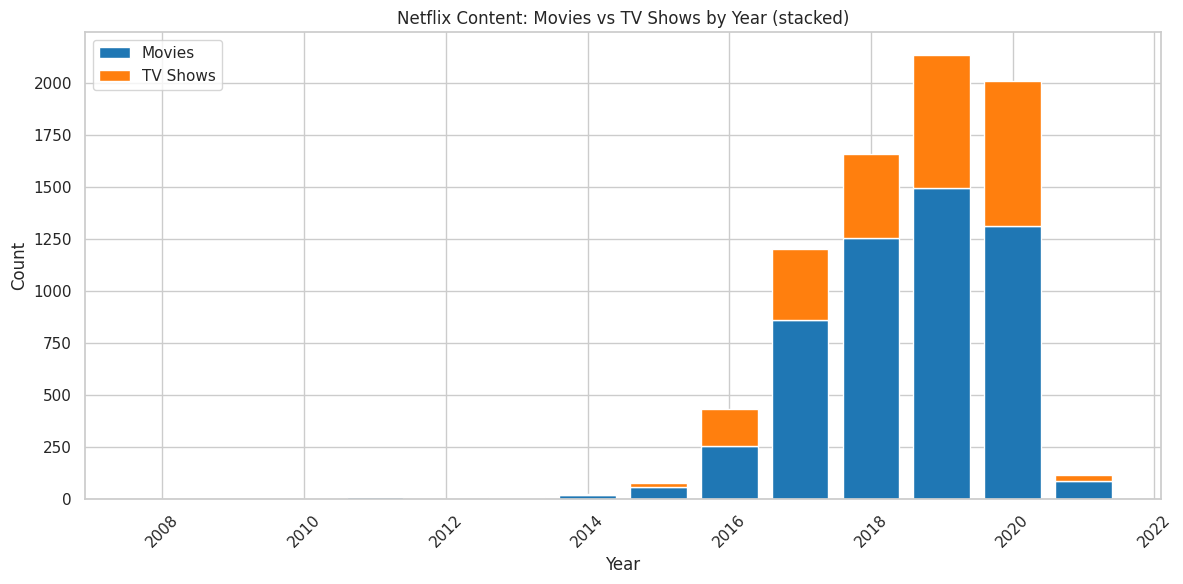


Interpretation: Observe how the catalog composition between Movies and TV Shows changed over time.


In [15]:

# Movies vs TV Shows trend (robust)
# Detect column that contains 'Movie'/'TV Show' values (Category, Type, etc.)
type_col = None
for c in df.columns:
    if df[c].astype(str).str.contains('Movie|TV Show', case=False, na=False).any():
        type_col = c; break

if type_col is None:
    print('Could not detect a column containing Movie/TV Show labels. Columns are:', list(df.columns))
else:
    plot_df = df.dropna(subset=['year', type_col]).copy()
    plot_df = plot_df[plot_df['year'].between(2008, 2025)]
    if plot_df.empty:
        print('No rows after filtering by year and type — cannot plot.')
    else:
        counts = plot_df.groupby(['year', type_col]).size().unstack(fill_value=0).sort_index()
        counts = counts.apply(pd.to_numeric, errors='coerce').fillna(0)
        # aggregate columns that represent movies or shows (case-insensitive)
        movie_cols = [c for c in counts.columns if 'movie' in str(c).lower()]
        show_cols = [c for c in counts.columns if ('show' in str(c).lower() or 'tv' in str(c).lower())]
        movies = counts[movie_cols].sum(axis=1) if movie_cols else pd.Series(0, index=counts.index)
        shows = counts[show_cols].sum(axis=1) if show_cols else pd.Series(0, index=counts.index)
        years = counts.index.astype(int)
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12,6))
        ax.bar(years, movies, label='Movies', color='#1f77b4')
        ax.bar(years, shows, bottom=movies, label='TV Shows', color='#ff7f0e')
        ax.set_title('Netflix Content: Movies vs TV Shows by Year (stacked)')
        ax.set_xlabel('Year'); ax.set_ylabel('Count'); ax.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        print('\nInterpretation: Observe how the catalog composition between Movies and TV Shows changed over time.')


## Objective 2: EDA - Top Genres and Yearly Trends

We identify the top genres and plot a horizontal bar chart. Then we plot yearly trends for the top 5 genres with short interpretation notes.


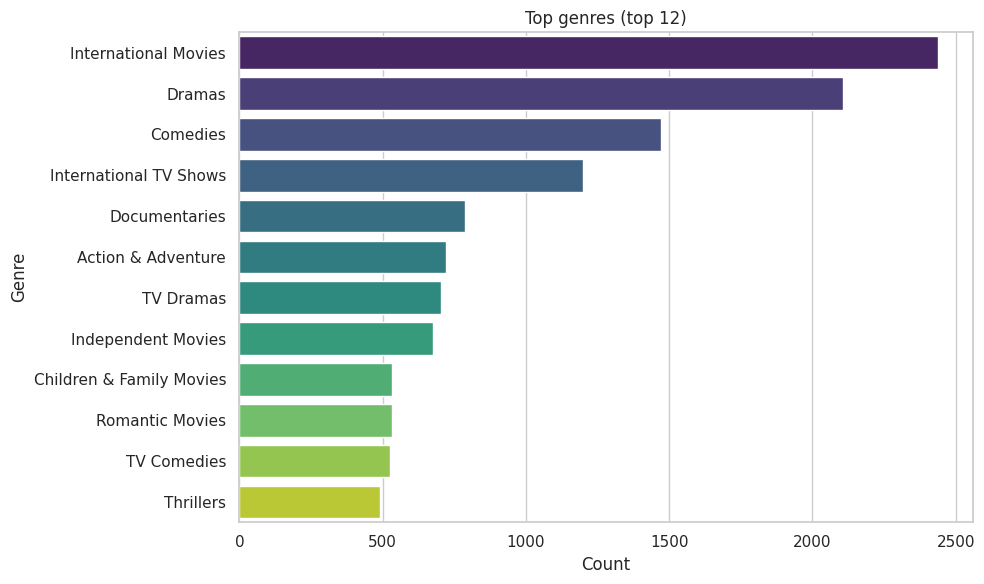


Interpretation: The bar chart above shows which genres dominate the catalog.


In [16]:

# Top genres
if 'listed_in' not in df.columns:
    print('No genre column detected (expected "listed_in"). Columns:', list(df.columns))
else:
    all_genres = df['listed_in'].dropna().astype(str).str.split(',')
    genre_list = [g.strip() for sub in all_genres for g in sub]
    genre_counts = pd.Series(genre_list).value_counts()
    top10 = genre_counts.head(12)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    sns.barplot(x=top10.values, y=top10.index, palette='viridis')
    plt.title('Top genres (top 12)'); plt.xlabel('Count'); plt.ylabel('Genre'); plt.tight_layout(); plt.show()
    print('\nInterpretation: The bar chart above shows which genres dominate the catalog.')

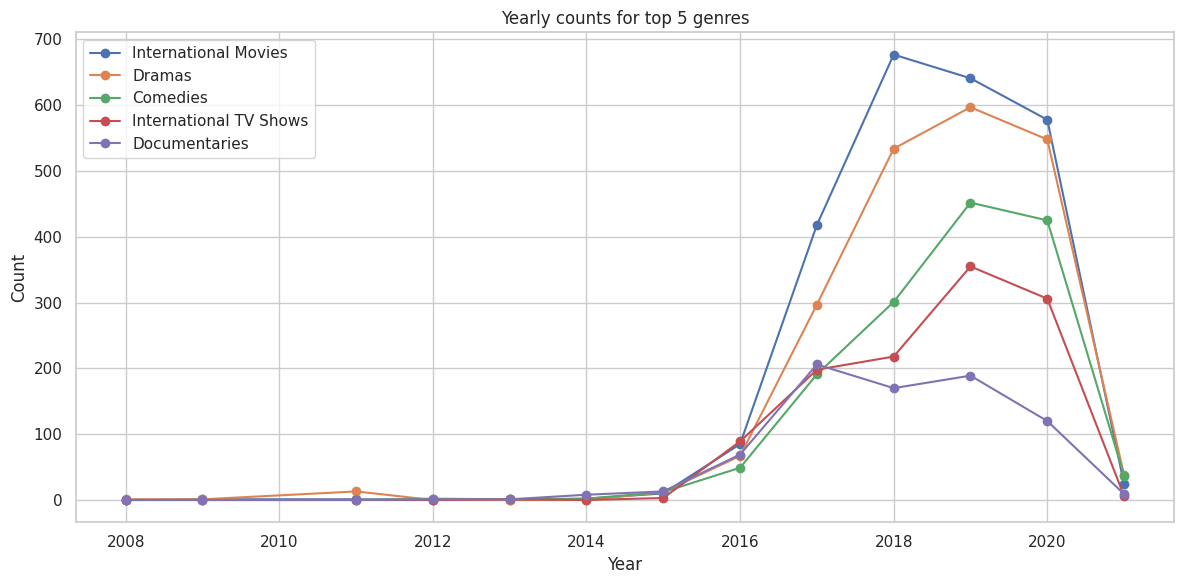


Interpretation: Lines show how interest in each top genre changed over time.


In [17]:

# Yearly trends for top 5 genres
if 'listed_in' not in df.columns or df['year'].isna().all():
    print('Skipping yearly genre trends because listed_in or year is missing.')
else:
    tmp = df.dropna(subset=['year','listed_in']).copy()
    tmp['genres_list'] = tmp['listed_in'].astype(str).str.split(',').apply(lambda x: [g.strip() for g in x])
    exploded = tmp.explode('genres_list')
    top5 = exploded['genres_list'].value_counts().head(5).index.tolist()
    trend = exploded[exploded['genres_list'].isin(top5)].groupby(['year','genres_list']).size().unstack(fill_value=0).sort_index()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    for g in top5:
        if g in trend.columns:
            plt.plot(trend.index, trend[g], marker='o', label=g)
    plt.title('Yearly counts for top 5 genres'); plt.xlabel('Year'); plt.ylabel('Count'); plt.legend(); plt.tight_layout(); plt.show()
    print('\nInterpretation: Lines show how interest in each top genre changed over time.')


## Objective 3: EDA - Country-wise Contributions

We identify the top countries contributing titles and plot a horizontal bar chart.


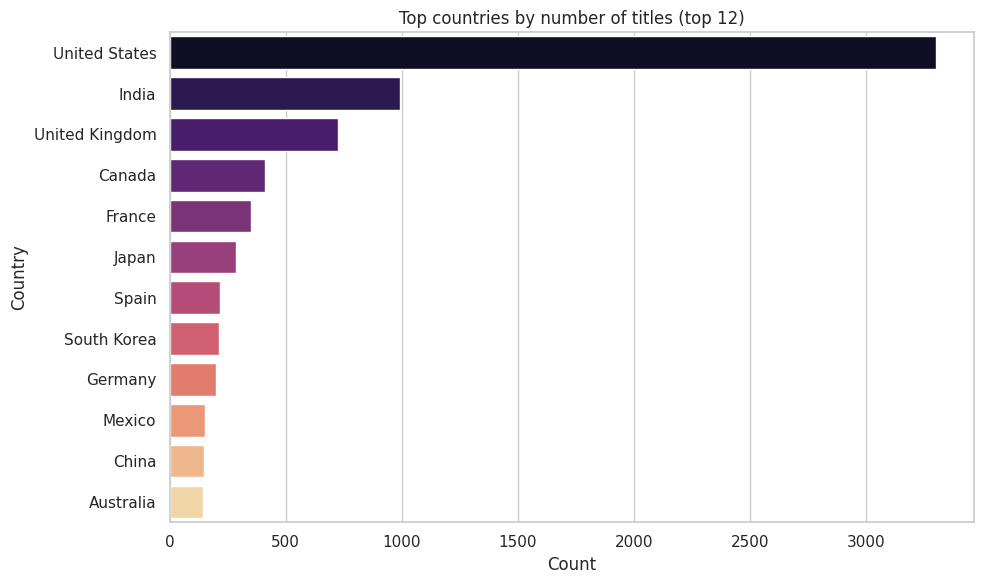


Interpretation: Countries with many titles often represent production hubs or licensing focus.


In [18]:

# Country-wise contributions
country_col = next((c for c in df.columns if 'country' in c.lower()), None)
if country_col is None:
    print('No country column found; skipping country analysis. Columns:', list(df.columns))
else:
    countries = df[country_col].dropna().astype(str).str.split(',').apply(lambda x: [c.strip() for c in x]).explode()
    top_countries = countries.value_counts().head(12)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')
    plt.title('Top countries by number of titles (top 12)'); plt.xlabel('Count'); plt.tight_layout(); plt.show()
    print('\nInterpretation: Countries with many titles often represent production hubs or licensing focus.')


## Analyses: EDA - Ratings Distribution

We inspect content ratings to understand audience targeting.


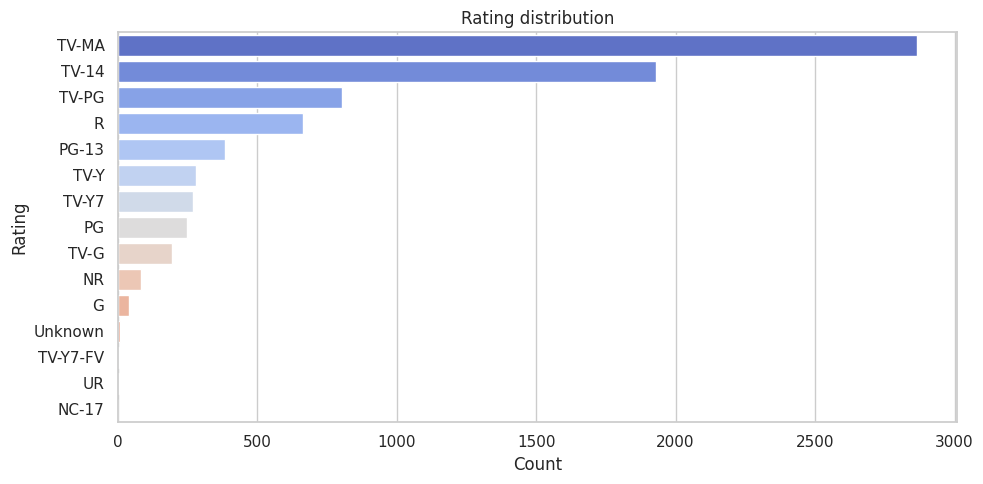


Interpretation: See dominant rating categories to align content with audience segments.


In [19]:

# Ratings distribution
rating_col = next((c for c in df.columns if 'rating' in c.lower()), None)
if rating_col is None:
    print('No rating column found; skipping rating distribution.')
else:
    rating_counts = df[rating_col].fillna('Unknown').value_counts().head(20)
    plt.figure(figsize=(10,5))
    sns.barplot(x=rating_counts.values, y=rating_counts.index, palette='coolwarm')
    plt.title('Rating distribution'); plt.xlabel('Count'); plt.tight_layout(); plt.show()
    print('\nInterpretation: See dominant rating categories to align content with audience segments.')

In [20]:

# Top directors and cast (if present)
dir_col = next((c for c in df.columns if 'director' in c.lower()), None)
cast_col = next((c for c in df.columns if 'cast' in c.lower() or 'actor' in c.lower()), None)

if dir_col and dir_col in df.columns:
    dirs = df[dir_col].dropna().astype(str).str.split(',').apply(lambda x: [d.strip() for d in x]).explode()
    display(dirs.value_counts().head(15))
else:
    print('No director column found.')

if cast_col and cast_col in df.columns:
    casts = df[cast_col].dropna().astype(str).str.split(',').apply(lambda x: [p.strip() for p in x]).explode()
    display(casts.value_counts().head(20))
else:
    print('No cast/actors column found.')

,count
Director,
Jan Suter,21
Raúl Campos,19
Marcus Raboy,16
Jay Karas,15
Cathy Garcia-Molina,13
Jay Chapman,12
Youssef Chahine,12
Martin Scorsese,12
Steven Spielberg,10


,count
Cast,
Anupam Kher,42
Shah Rukh Khan,35
Om Puri,30
Naseeruddin Shah,30
Akshay Kumar,29
Takahiro Sakurai,29
Paresh Rawal,27
Yuki Kaji,27
Boman Irani,27



## Machine Learning: Clustering Content

We apply KMeans clustering on numeric features (duration, year) after preprocessing to discover natural groupings of titles. This helps identify content cohorts (for example: short movies, long-form series, recent originals, classic content).


Clustering dataset size: (7691, 2)


duration_num                      year        
                mean median count         mean  median
cluster                                               
0           5.541331    1.0  1984  2019.204637  2019.0
1         107.107513  103.0  3860  2019.053627  2019.0
2          61.532756   74.0  1847  2016.617217  2017.0

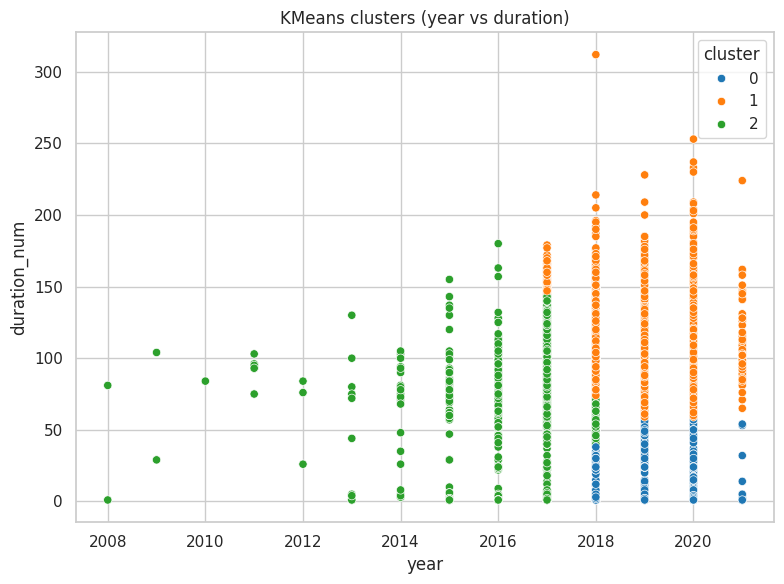

In [21]:

# KMeans clustering on duration_num and year
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
cluster_df = df[['duration_num','year']].dropna().copy()
cluster_df['duration_num'] = pd.to_numeric(cluster_df['duration_num'], errors='coerce')
cluster_df['year'] = pd.to_numeric(cluster_df['year'], errors='coerce')
cluster_df = cluster_df.dropna().reset_index(drop=True)
print('Clustering dataset size:', cluster_df.shape)
if cluster_df.shape[0] < 10:
    print('Not enough data for clustering (need >=10 rows).')
else:
    scaler = StandardScaler()
    X = scaler.fit_transform(cluster_df[['duration_num','year']])
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
    cluster_df['cluster'] = kmeans.labels_
    display(cluster_df.groupby('cluster').agg({'duration_num':['mean','median','count'],'year':['mean','median']}))
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=cluster_df, x='year', y='duration_num', hue='cluster', palette='tab10')
    plt.title('KMeans clusters (year vs duration)'); plt.tight_layout(); plt.show()


## Machine Learning: Trend Forecasting (Linear Regression)

We build a simple linear regression model to forecast total number of titles per year based on historical yearly counts. This is a simple baseline to understand directionality (growth/decline) in catalog size.


LinearRegression RMSE (on training data): 573.88 titles


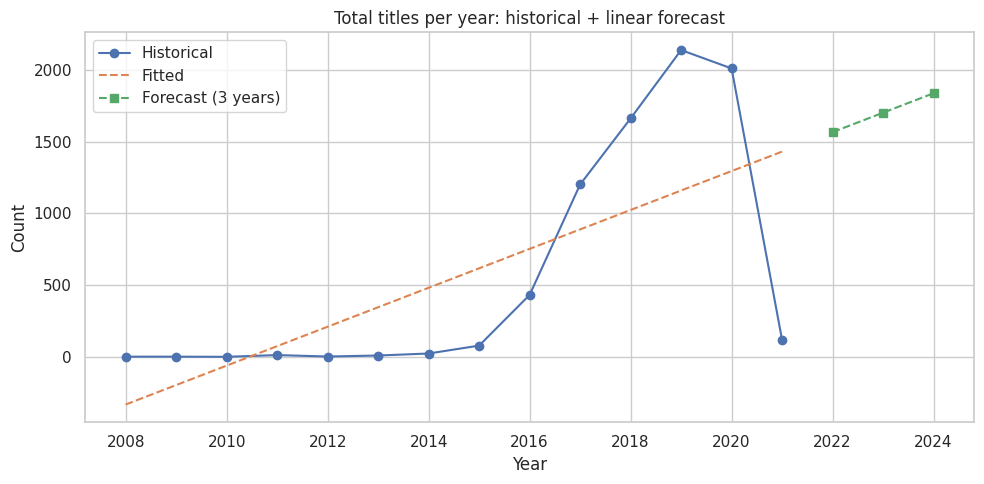

,year,forecast
0,2022,1565
1,2023,1701
2,2024,1836


In [22]:
# Forecasting total titles per year (simple Linear Regression baseline) - version-safe RMSE computation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

yearly = df.dropna(subset=['year']).groupby('year').size().reset_index(name='count').sort_values('year')
yearly = yearly[(yearly['year']>=2008) & (yearly['year']<=2025)]
if yearly.shape[0] < 3:
    print('Not enough yearly points for forecasting. Found rows:', yearly.shape[0])
    display(yearly)
else:
    X = yearly[['year']].astype(int)
    y = yearly['count'].astype(int)
    model = LinearRegression().fit(X, y)
    preds = model.predict(X)
    # compute RMSE in a version-safe way (sqrt of MSE)
    rmse = float(np.sqrt(mean_squared_error(y, preds)))
    print(f'LinearRegression RMSE (on training data): {rmse:.2f} titles')
    # Forecast next 3 years
    last_year = int(yearly['year'].max())
    future_years = pd.DataFrame({'year':[last_year+1, last_year+2, last_year+3]})
    future_preds = model.predict(future_years)
    plt.figure(figsize=(10,5))
    plt.plot(yearly['year'], yearly['count'], marker='o', label='Historical')
    plt.plot(yearly['year'], preds, linestyle='--', label='Fitted')
    plt.plot(future_years['year'], future_preds, marker='s', linestyle='--', label='Forecast (3 years)')
    plt.title('Total titles per year: historical + linear forecast'); plt.xlabel('Year'); plt.ylabel('Count'); plt.legend(); plt.tight_layout(); plt.show()
    display(pd.DataFrame({'year': future_years['year'], 'forecast': future_preds.round().astype(int)}))


In [23]:

# Save cleaned copy for reporting
out_path = '/content/netflix_clean_for_report_v3.csv'
try:
    df.to_csv(out_path, index=False)
    print('Saved cleaned dataset to', out_path)
except Exception as e:
    print('Could not save cleaned CSV:', e)

# Final conclusions (short)
print('\nConclusions & Strategic Recommendations:')
print('- Use the Movies vs TV Shows trend to guide investment in series vs films.')
print('- Invest in rising genres and underrepresented countries.')
print('- Use clusters to design tailored promotions; use better time-series models for forecasting.')


Saved cleaned dataset to /content/netflix_clean_for_report_v3.csv

Conclusions & Strategic Recommendations:
- Use the Movies vs TV Shows trend to guide investment in series vs films.
- Invest in rising genres and underrepresented countries.
- Use clusters to design tailored promotions; use better time-series models for forecasting.



## Insights & Strategic Recommendations


- **Catalog growth:** Check the trend plot & forecast. If catalog growth is slowing, consider accelerating original productions.


- **Genre focus:** Invest in genres that show recent upward trends (see yearly top-5 genre plot).


- **Regional strategy:** Prioritize local-language content in underrepresented countries showing growth potential.


- **Cluster-driven content bundles:** Use clustering cohorts to create tailored promotional campaigns or content bundles.


---

**Notes & next steps:**
- For better forecasting, use ARIMA/Prophet models and include external signals (subscriber counts, regional performance).
- For clustering, include more features (e.g., popularity metrics, user ratings) if available.


